# Problem 2
The Jacobi method was used to numerically solve the poisson equation for an electric dipole.  The poisson equation for the electric potential is given by,

$$
\nabla^2 V(\mathbf{r}) = \sum_i \frac{\partial^2 V}{\partial r_i^2} = -\alpha\rho(\mathbf{r})
$$

with potential $V$ and source density $\rho$. In the case of Coulomb's law, $\rho$ is the charge density and $V$ is the electric potential, with $\alpha = 1/\epsilon_0$.  For the sake of this problem, we assume $\alpha = 1$.

The discretization for the Jacobi method is given by,

$$
V_{i,j}^{n+1} = \frac{1}{4} \left[ V_{i+1,j}^{n} + V_{i-1,j}^{n} + V_{i,j+1}^{n} + V_{i,j-1}^{n} + h^2 \rho_{i,j} \right].
$$



In [45]:
#!/usr/bin/env python3
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import math

In [46]:
import numpy as np
import time
import cmath

class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        self.L = L                    # number of interior points in x and y        
        self.omega = 2 / (1 + math.pi*self.L) # over-relaxation parameter
        self.N = L + 2                # interior plus two boundary points
        N=self.N
        self.V = np.zeros( (N, N) )   # potential to be found
        self.VNew = np.zeros( (N, N) )# new potential after each step
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        self.nsmooth = 3              # smoothing steps for multigrid method
        self.rho = np.array( rho_init )
        self.method=method        
        self.calcError = calcError
        self.error  = 0. if self.calcError else None
        self.errors = [] if self.calcError else None


    def __call__(self):
        return getattr(self,self.method)()

    def update(self):
        if self.calcError :
            self.error = np.sum( np.abs(self.V - self.VNew) ) / self.V.size
        self.V[:,:] = self.VNew[:,:]
        if self.calcError :
            self.errors.append(self.error)
            return self.error
        else :
            return None

        
    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew,self.V,self.h,self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = np.add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            0.25*h**2 * rho[1:-1,1:-1]])
        return u



### Set Parameters and Run Jacobi Method to Convergence

The solver was iterated until the error reached a certain tolerance (i.e. 1e-6).

In [47]:
L = 250
N = L+2
q = 10             # point charge
i = N // 2                    # center of lattice
h = 1/(L+1)
rho = np.zeros( (N,N))
rho[i,i+round(L/4)] = q / h**2    # charge density
rho[i,i-round(L/4)] = -q / h**2    # charge density

#nsteps = 10000
#steps = np.arange(nsteps)
p = Poisson(L,rho, 'Jacobi')
#for i in steps : 
#    p()
    
ierr = 9999
tol = 1e-6
i = 0
while ierr > tol :    
        ierr = p()
        i = i + 1

### Check Convergence

Text(0, 0.5, 'Error')

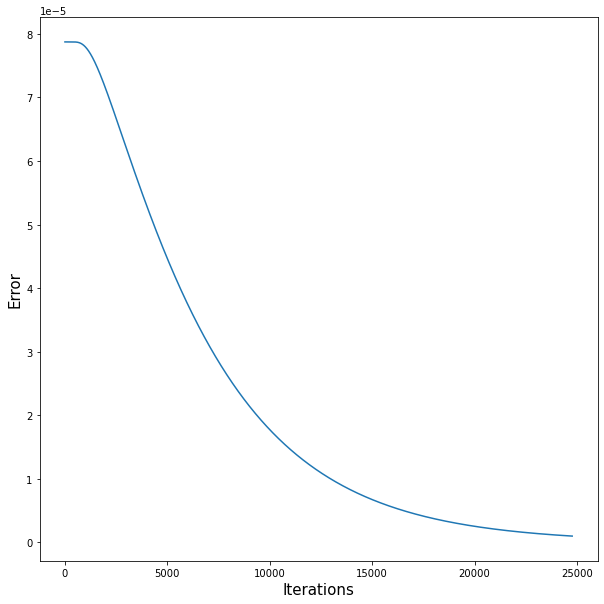

In [48]:
L_vals=[10,50,100,150,200,250]
i_vals=[203,2176,5582,10859,17342,24770]
fig = plt.figure(1,figsize=(10,10))
plt.plot(np.arange(0, i, 1), p.errors)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Error", fontsize=15)

Text(0, 0.5, 'Iterations to Convergence')

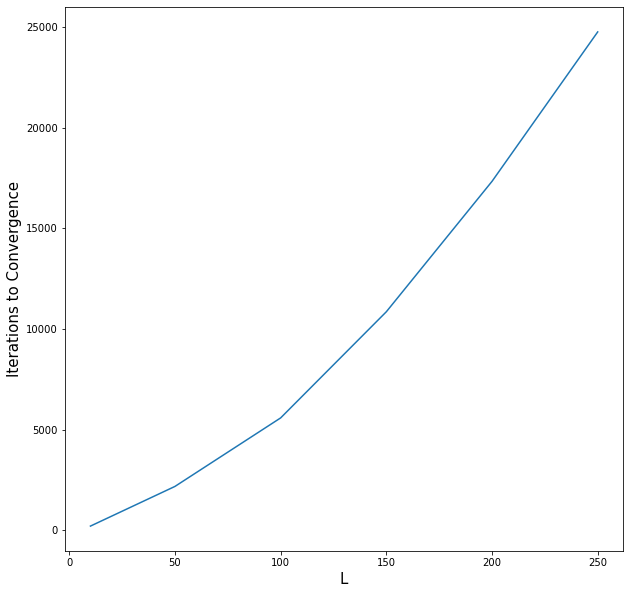

In [49]:
fig = plt.figure(figsize=(10,10))
plt.plot(L_vals, i_vals)
plt.xlabel("L", fontsize=15)
plt.ylabel("Iterations to Convergence", fontsize=15)

Text(0, 0.5, 'Iterations to Convergence')

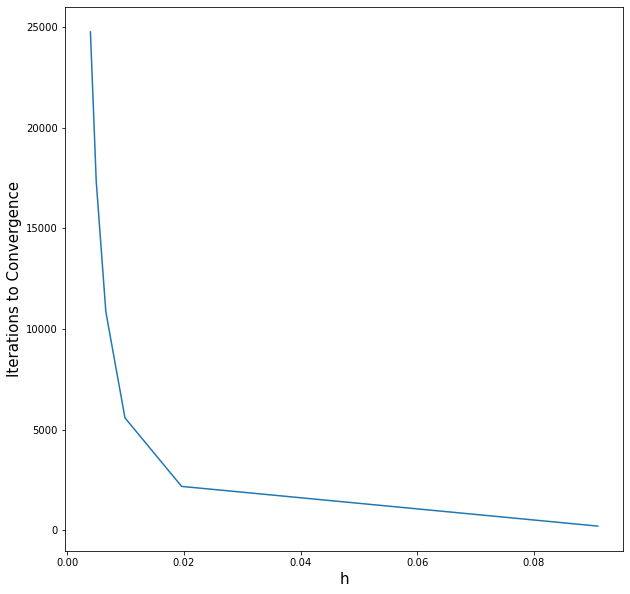

In [50]:
h_vals = [1/(L_vals[0]+1), 1/(L_vals[1]+1), 1/(L_vals[2]+1), 1/(L_vals[3]+1), 1/(L_vals[4]+1), 1/(L_vals[5]+1)]
fig = plt.figure(figsize=(10,10))
plt.plot(h_vals, i_vals)
plt.xlabel("h", fontsize=15)
plt.ylabel("Iterations to Convergence", fontsize=15)

### Show Final Calculated Potential

Text(0.5, 0, 'y')

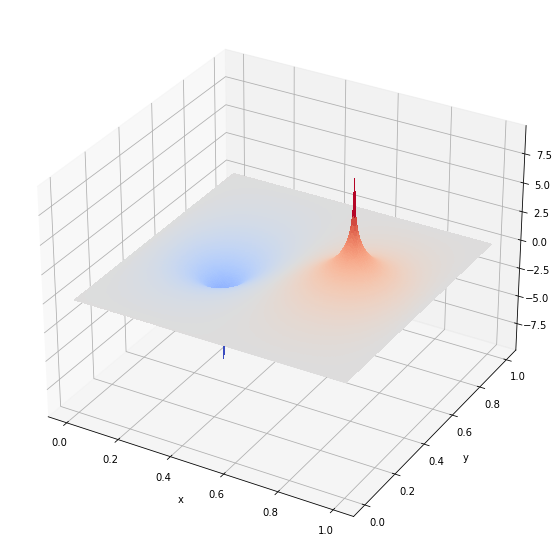

In [51]:
# Define the axes
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(p.L+2), p.h)
# Get the grid
X, Y = np.meshgrid(x, y)
# Set Z to the poisson V[i][j]
Z = np.array( p.V )

if X.shape != Z.shape:
    new_row = np.zeros(len(Z))
    Z = np.vstack([Z, new_row])  
    print(Z.shape)
    new_col = np.zeros((len(Z),1))
    print(new_col.shape)
    Z = np.hstack([Z, new_col])

fig = plt.figure(2,figsize=(10, 10))
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

## Plot expected Potential

Text(0.5, 0, 'y')

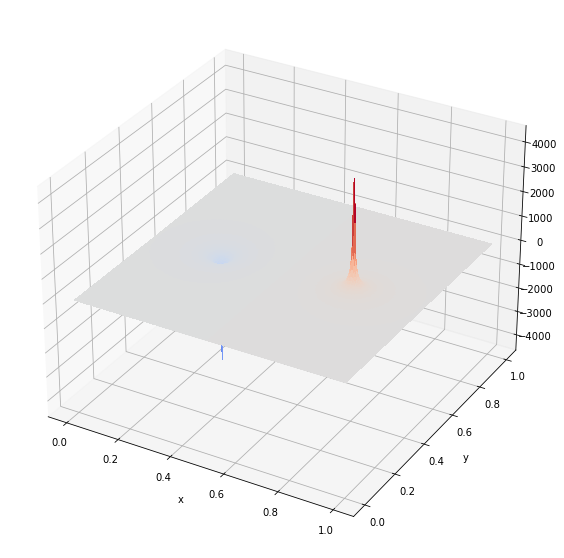

In [52]:
rminus = (((X - 0.25)**2 + (Y - 0.5)**2)**(1/2))
rplus = (((X - 0.75)**2 + (Y - 0.5)**2)**(1/2))

Z_exp = ((q/rplus)+(-q/rminus))

fig = plt.figure(3,figsize=(10,10))
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z_exp, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

#### 

### Plot Error

The error is calculated by subtracting the expected potential from the potential calculated using the Jacobi method.

Text(0.5, 0, 'y')

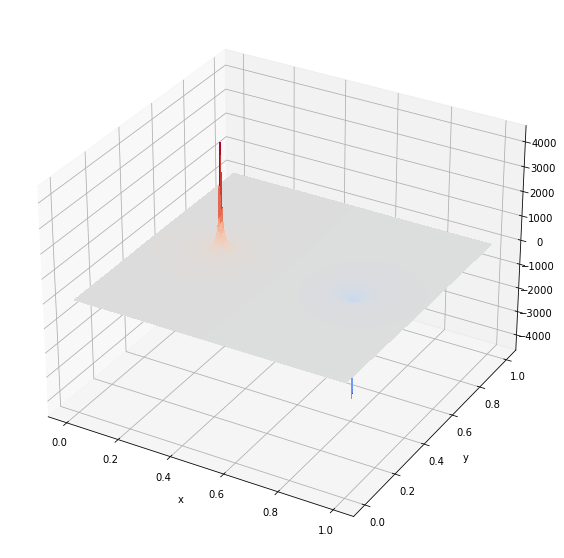

In [53]:
Z_res = Z - Z_exp

fig = plt.figure(4,figsize=(10,10))
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z_res, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

In [62]:
print(np.amax(Z_exp))
print(np.amax(Z))

Z_exp_vals = [4.26936250174777, 6.953554417664485, 8.06421347691531, 8.708123148675291, 9.163482573489475, 9.514367684522263]
Z_vals = [175.91598164182267, 892.1216738615273, 1786.84241379717, 2681.1041145853546, 3575.647181287311, 4469.984738337996]

4469.984738337996
9.514367684522263


Text(0.5, 1.0, 'Convergence of $Z_{max}$')

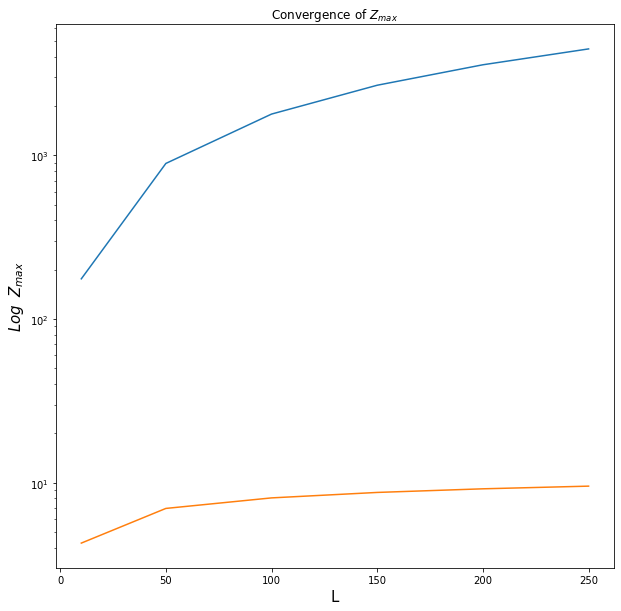

In [64]:
fig = plt.figure(figsize=(10,10))
plt.plot(L_vals, Z_vals)
plt.plot(L_vals, Z_exp_vals)
plt.yscale("Log")
plt.xlabel("L", fontsize=15)
plt.ylabel("$Log \;\; Z_{max}$", fontsize=15)
plt.title("Convergence of $Z_{max}$")

## Comments

Comparing the plots made by the Jacobi solver to the expected plots, it is clear that, while the plots are similar in structure, the results from the Jacobi method do not match the exact solution.  In the final plot, the maximum value of Z is compared between the analytic solution and the Jacobi method solution for all values of L teseted.  Both trend lines converge towards a single maximum value but the values being converged towards are very different between the two methods.

The other clear difference between the solutions, is the radius of the potentials.  In the analyitic solution, the potential peaks surrounding the particles in the dipole are tall but have very small radii.  In the jacobi solution, however, the peaks are shallower and have much larger radii where the potential dissipates.  Increasing L (or decreasing h), creates a tighter peak but also increases computational cost so peaks resembling the analytic solution can not be calculated.